In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## The Toast Myth

We saw the Mythbusters crew do an experiment with 48 pieces of toast, where 29 landed butter side up and 19 butter side down.  Let's see if we can figure out how likely this outcome would be, if toast was equally likely to land on either side.  In particular, we'll play a "what-if" game: what if toast was equally likely to land on both sides?  Let's simulate what would happen, under that assumption.

In [2]:
sides = make_array('Butter Side Up', 'Butter Side Down')

In [3]:
possible_outcomes = Table().with_column('Outcome', sides)

In [4]:
possible_outcomes

Outcome
Butter Side Up
Butter Side Down


In [50]:
simulated_experiment = possible_outcomes.sample(48)

In [51]:
simulated_experiment

Outcome
Butter Side Up
Butter Side Up
Butter Side Up
Butter Side Up
Butter Side Up
Butter Side Down
Butter Side Down
Butter Side Up
Butter Side Down
Butter Side Up


In [52]:
simulated_experiment.group('Outcome')

Outcome,count
Butter Side Down,26
Butter Side Up,22


In [8]:
def count_up(sample):
    counts = sample.group('Outcome').where('Outcome', 'Butter Side Up')
    number_up = counts.column('count').item(0)
    return number_up

In [9]:
count_up(simulated_experiment)

21

## Simulation

Above we saw how to simulate an episode of the TV show (i.e., one experiment), under the "what-if" assumption that toast is equally likely to land on both sides.  Now we're going to repeat the simulation 10000 times, and keep track of the statistic (the number of times the toast landed butter-side-up) we get from each simulated TV episode.

In [10]:
counts = make_array()
for i in np.arange(10000): # 10000 repetitions
    one_simulated_episode = possible_outcomes.sample(48)
    number_up = count_up(one_simulated_episode)
    counts = np.append(counts, number_up)
results = Table().with_column('Number that landed butter-side-up', counts)

In [11]:
results

Number that landed butter-side-up
29
24
16
20
23
17
26
25
23
22


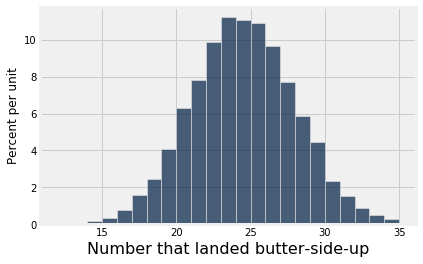

In [12]:
results.hist(bins=np.arange(12,36,1))

In [13]:
results.where('Number that landed butter-side-up',
              are.above_or_equal_to(29)).num_rows / 10000

0.1004

## Alameda County Juries

In [20]:
# Data from an ACLU 2010 report
# Racial and Ethnic Disparities in Alameda County Jury Pools
# https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf

alameda = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

alameda.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


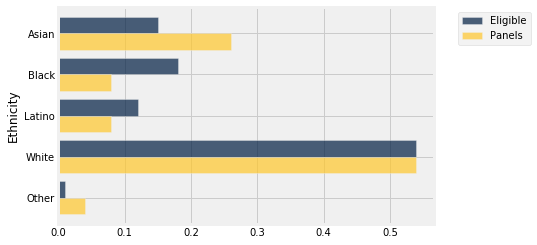

In [21]:
alameda.barh(0)

## Total Variation Distance

In [22]:
diff = alameda.with_column('Difference',
                    alameda.column('Eligible') - alameda.column('Panels'))
diff

Ethnicity,Eligible,Panels,Difference
Asian,15%,26%,-0.11
Black,18%,8%,0.1
Latino,12%,8%,0.04
White,54%,54%,0
Other,1%,4%,-0.03


In [23]:
abs_diff = diff.with_column('Abs. Difference',
                        np.abs(diff.column('Difference')))
abs_diff

Ethnicity,Eligible,Panels,Difference,Abs. Difference
Asian,15%,26%,-0.11,0.11
Black,18%,8%,0.1,0.1
Latino,12%,8%,0.04,0.04
White,54%,54%,0,0
Other,1%,4%,-0.03,0.03


In [24]:
sum(abs_diff.column('Abs. Difference')) / 2

0.14

In [25]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

In [26]:
def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

In [27]:
table_tvd(alameda, 'Eligible', 'Panels')

0.14

## Simulating the statistic

In [28]:
def get_one_simulated_panel():
    return alameda.select('Ethnicity').sample(1453, weights=alameda.column('Eligible'))

In [29]:
def simulate_once():
    simulated_panel = get_one_simulated_panel()
    counts = simulated_panel.group('Ethnicity')
    sim_proportions = counts.select('Ethnicity').with_column('Random',
                                    counts.column('count') / 1453)
    sim_proportions.set_format(1, PercentFormatter(0))
    return alameda.join('Ethnicity', sim_proportions)

In [30]:
simulate_once()

Ethnicity,Eligible,Panels,Random
Asian,15%,26%,15%
Black,18%,8%,19%
Latino,12%,8%,13%
Other,1%,4%,1%
White,54%,54%,53%


In [31]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # 1000 repetitions of the simulation
    sim_results = simulate_once()
    tvds = np.append(tvds, table_tvd(sim_results, 'Eligible', 'Random'))

results = Table().with_column('TVD', tvds)
results

TVD
0.0196077
0.0321335
0.0105712
0.0231039
0.0191604
0.0103716
0.00488644
0.00478321
0.0165313
0.00916036


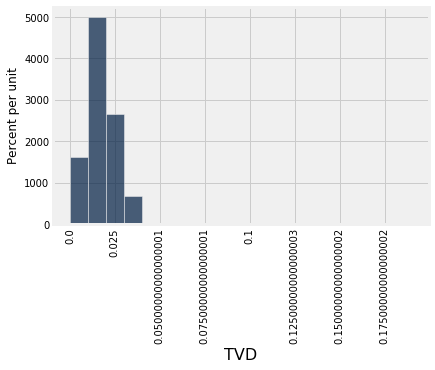

In [32]:
results.hist(bins=np.arange(0, 0.2, 0.01))

## P-value

In [33]:
results.where(0, are.above_or_equal_to(0.14)).num_rows / results.num_rows

0.0

## Addendum: Alameda County Race & Ethnicity Distribution

In [34]:
# According to the 2010 Census, https://www.census.gov/2010census/popmap/

alameda_race = Table(['Race', 'Population']).with_rows([
    ['White', 649122],
    ['African American', 190451],
    ['Asian', 394560],
    ['AIAN', 9799],
    ['NHPI', 12802],
    ['Some Other Race', 162540],
    ['Two or more Races', 90997],
])

alameda_race.set_format(1, DistributionFormatter).show()

alameda_ethnicity = Table(['Ethnicity', 'Population']).with_rows([
    ['Hispanic or Latino', 339889],
    ['Not Hispanic or Latino', 1170382],
])

alameda_ethnicity.set_format(1, DistributionFormatter).show()

Race,Population
White,42.98%
African American,12.61%
Asian,26.13%
AIAN,0.65%
NHPI,0.85%
Some Other Race,10.76%
Two or more Races,6.03%


Ethnicity,Population
Hispanic or Latino,22.51%
Not Hispanic or Latino,77.49%


In [35]:
alameda

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


## Swain v. Alabama, repeat

In [40]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


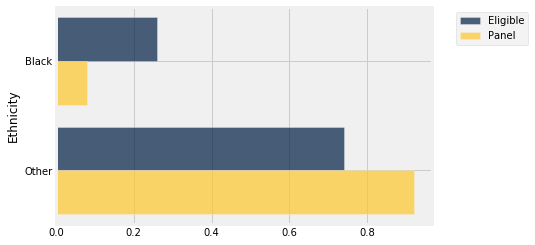

In [41]:
swain.barh(0)

In [42]:
def simulate_one_swain(number):
    simulated_panel = swain.select('Ethnicity').sample(number, weights=swain.column('Eligible'))
    counts = simulated_panel.group('Ethnicity')
    sim_proportions = counts.select('Ethnicity').with_column('Random',
                                    counts.column('count') / number)
    sim_proportions.set_format(1, PercentFormatter(0))
    return swain.join('Ethnicity', sim_proportions)

In [45]:
simulate_one_swain(100)

Ethnicity,Eligible,Panel,Random
Black,26%,8%,21%
Other,74%,92%,79%


In [46]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(10000): # 10000 repetitions of the simulation
    sim_results = simulate_one_swain(100)
    tvds = np.append(tvds, table_tvd(sim_results, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0
0.05
0.07
0.08
0.06
0.04
0.03
0.02
0.02
0


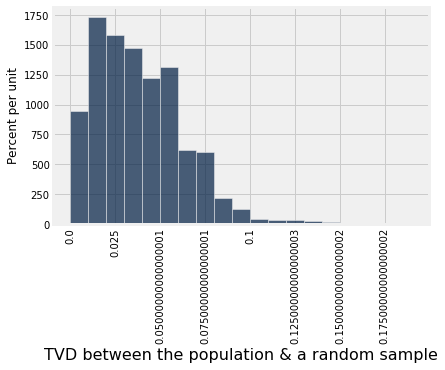

In [47]:
results.hist(bins=np.arange(0, 0.20, 0.010))

In [48]:
# P value
results.where(0, are.above_or_equal_to(0.14)).num_rows / results.num_rows

0.0026